In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
import sys
import pickle
import yaml
import dcargs
import pandas as pd

sys.path.append("..") 

from experiment import ExperimentParameters
import glob
from tqdm import tqdm
from yaml.loader import SafeLoader

path = "/home/mohsen/Project/colab/collective-decison-making-with-direl/results/"
sys.path.append(path)


In [2]:
from multiprocessing import Pool
import networkx as nx

def parse_experiment_data_par(file_path):
#     print("File Path is: " + file_path)
    try:
        pickleFileName = file_path+"/data.pickle5"
        yamlFileName = file_path+"/config.yaml"

        with open(pickleFileName, "rb") as f:
            resFile = pickle.load(f)

        with open(yamlFileName, 'r') as f:
            configData = dcargs.from_yaml(ExperimentParameters, f)
            
        
        n_agents = configData.network_params.n_agents
        steps = configData.steps
        z_gt = configData.true_value
        
        # not checked yet
        range_agent_measurement_noise = configData.network_params.max_agent_measurement_noise - configData.network_params.min_agent_measurement_noise
        mean_agent_measurement_noise = 0.5*(configData.network_params.max_agent_measurement_noise + configData.network_params.min_agent_measurement_noise)
        env_noise_std = configData.env_noise_std
        scalar_param1 = configData.network_params.scalar_param1
        weight_own_belief = configData.network_params.weight_own_belief

        colData = resFile['collective_data']
        adjc = colData['connectivity']
        agntData = colData['agent_data']
        
        # print("nAgents: " + str(n_agents) + ", steps: " + str(steps));
        # print("agnt data: ", len(agntData))

        zArr = np.zeros((n_agents,steps))
        pArr = zArr.copy()

        for i in range(n_agents):
            z = agntData[i].belief_mean
            std = agntData[i].belief_std
            zArr[i,:] = z
            pArr[i,:] = std

        avgZArr = np.mean(zArr, axis=0)
        E_t = (avgZArr-z_gt)**2
        E_p2 = (zArr - avgZArr)**2
        E_p = np.mean(E_p2, axis=0)
        E_a = E_t + E_p

        G = nx.from_numpy_array(adjc[0].cpu().detach().numpy())
        degreeDist = np.array(G.degree())[:, 1]
        clustCoef = np.array(list(nx.clustering(G).values()))
        eigVec = np.array(list(nx.eigenvector_centrality_numpy(G).values()))

        L = nx.normalized_laplacian_matrix(G)
        eigVal = np.linalg.eigvals(L.A);

        d = {"Trueness Error": E_t, "Precision Error": E_p, "Accuracy Error": E_a, "Collective Mean": avgZArr, 
            "Number of Agents": [n_agents for _ in range(steps)], "True Value": [z_gt for _ in range(steps)], 
            "Timestep": [i for i in range(steps)],
            "mean agent measurement noise": [mean_agent_measurement_noise for _ in range(steps)],
            "range agent measurement noise": [range_agent_measurement_noise for _ in range(steps)],
            "std environment noise": [env_noise_std for _ in range(steps)],
            "scalar param1": [scalar_param1 for _ in range(steps)],
            "weight_own_belief": [weight_own_belief for _ in range(steps)],
             # ToDo: Calculate Network properties for each time-step, so that we can see the evolution of these properties over time
            "Netw num of Edges" : G.number_of_edges(),
            "Netw std degree" : np.std(degreeDist),
            "Netw mean degree" : np.mean(degreeDist),
            "Netw std eigVec" : np.std(eigVec),
            "Netw mean eigVec" : np.mean(eigVec),
            "Netw max eigVec" : np.max(eigVec),
            "Netw std CC" : np.std(clustCoef),
            "Netw mean CC" : np.mean(clustCoef),
            "Netw max CC" : np.max(clustCoef),
            "Netw std eigVal" : np.std(eigVal),
            "Netw mean eigVal" : np.mean(eigVal),
            "Netw max eigVal" : np.max(eigVal)}
        
        return pd.DataFrame.from_dict(d)
    except:
        print("Something Went Wrong!")

# def process_file(base_file_path):
def parse_experiments(base_file_path):
    pathes = glob.glob(os.path.join(base_file_path, "*"))
    pool = Pool(10)
    dataframes = pool.imap(parse_experiment_data_par, tqdm(pathes))#[479400:-1]))#[0:460000]))
    #   dataframes.append(parse_experiment_data_par(p))
    #   dataframes = [parse_experiment_data(p) for p in tqdm(pathes)]
    return pd.concat(dataframes, ignore_index=True)


# experiment_path = "/home/mohsen/Project/colab/collective-decison-making-with-direl/results/2022-10-29-15-36-50_test_grid_search_Bayes/" 
# experiment_path = "/home/mohsen/Project/colab/collective-decison-making-with-direl/results/2022-11-08-17-57-46_test_grid_search_Naive/"

# df = parse_experiments(experiment_path)

In [6]:
from multiprocessing import Pool
import networkx as nx

# experiment_name = "2022-11-24-15-26-41_test_grid_search_Naive"
experiment_name = "N100_2023-05-02-14-33-16_test_grid_search_Naive_centralized_random"

experiment_folder_path = path + "/" + experiment_name 

base_file_path = experiment_folder_path

pathes = glob.glob(os.path.join(base_file_path, "*"))
print(pathes[0])
file_path = pathes[2]
df_tst = parse_experiment_data_par(file_path)                    
            

/home/mohsen/Project/colab/collective-decison-making-with-direl/results//N100_2023-05-02-14-33-16_test_grid_search_Naive_centralized_random/results__df_withNet_updatedEigs.pickle
Something Went Wrong!


In [31]:
print(df_tst.weight_own_belief)

0    0.777778
1    0.777778
2    0.777778
3    0.777778
4    0.777778
5    0.777778
6    0.777778
7    0.777778
8    0.777778
9    0.777778
Name: weight_own_belief, dtype: float64


In [8]:
# experiment_name = "2022-10-29-15-36-50_test_grid_search_Bayes"
# /home/mohsen/Project/colab/collective-decison-making-with-direl/results/2022-11-24-/
# exp_name = "/home/mohsen/Project/colab/collective-decison-making-with-direl/results/"
# experiment_name = "2022-11-25-02-21-50_test_grid_search_Bayes"
experiment_name = "2022-11-24-15-26-41_test_grid_search_Naive"

experiment_folder_path = path + "/" + experiment_name 

dataFrame_path = path + "/" + experiment_name + "__df_withNet_NoAdjc.pickle"


In [ ]:
# df = parse_experiments(experiment_path + "/")
df = parse_experiments(experiment_folder_path)

df.to_pickle(dataFrame_path)

  0%|▍                                                                                                                        | 699/200000 [00:22<2:40:57, 20.64it/s]

# Loading the database file

In [5]:
pickleFileName = dataFrame_path

with open(pickleFileName, "rb") as f:
    df = pickle.load(f)

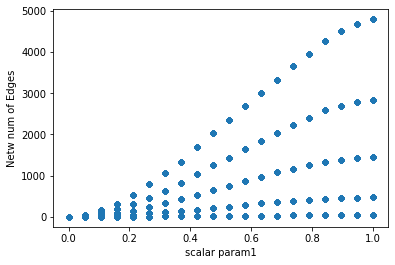

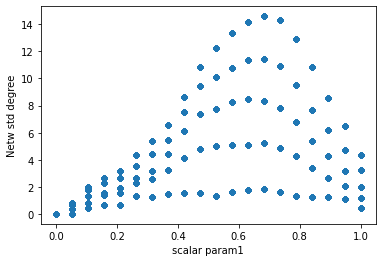

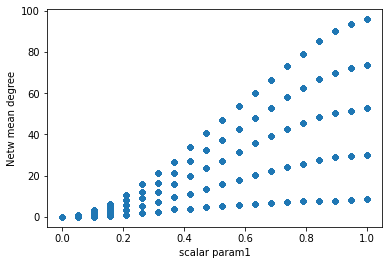

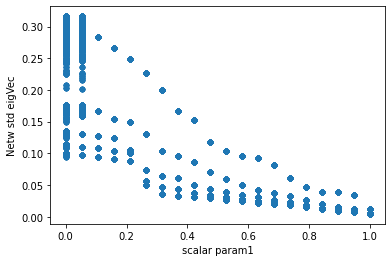

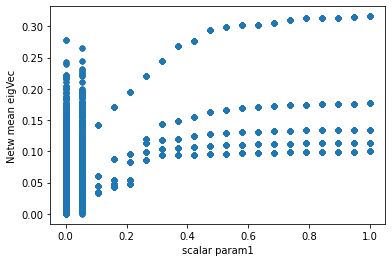

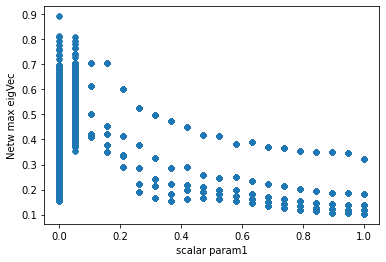

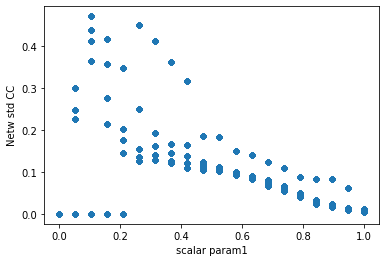

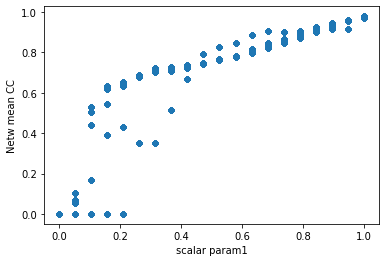

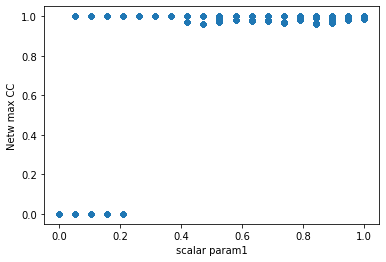

In [6]:
df.plot.scatter(x="scalar param1",y="Netw num of Edges");
df.plot.scatter(x="scalar param1",y="Netw std degree");
df.plot.scatter(x="scalar param1",y="Netw mean degree");

df.plot.scatter(x="scalar param1",y="Netw std eigVec");
df.plot.scatter(x="scalar param1",y="Netw mean eigVec");
df.plot.scatter(x="scalar param1",y="Netw max eigVec");

df.plot.scatter(x="scalar param1",y="Netw std CC");
df.plot.scatter(x="scalar param1",y="Netw mean CC");
df.plot.scatter(x="scalar param1",y="Netw max CC");

# df.plot.scatter(x="scalar param1",y="Netw std eigVal");
# df.plot.scatter(x="scalar param1",y="Netw mean eigVal");
# df.plot.scatter(x="scalar param1",y="Netw max eigVal");
# df.plot.hexbin(x="mean agent measurement noise",   y="scalar param1",C="Netw num of Edges", reduce_C_function=np.mean, gridsize=15);

In [7]:
df.shape

(40000, 22)

/home/mohsen/.local/lib/python3.8/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


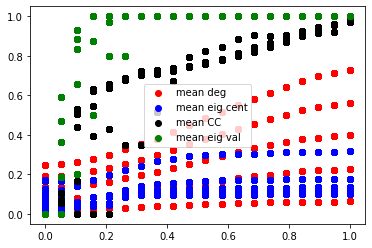

In [6]:
fig, ax = plt.subplots()
ax.scatter(x=df["scalar param1"], y=df["Netw mean degree"]/100, c="r", label="mean deg")
ax.scatter(x=df["scalar param1"], y=df["Netw mean eigVec"], c="b", label="mean eig cent")
ax.scatter(x=df["scalar param1"], y=df["Netw mean CC"], c="k", label="mean CC")
ax.scatter(x=df["scalar param1"], y=df["Netw mean eigVal"], c="g", label="mean eig val")
ax.legend()

# df.plot.scatter(x="scalar param1",y="Netw num of Edges");
# df.plot.scatter(x="scalar param1",y="Netw std degree");
# df.plot.scatter(x="scalar param1",y="Netw mean degree");

# df.plot.scatter(x="scalar param1",y="Netw std eigVec");
# df.plot.scatter(x="scalar param1",y="Netw mean eigVec");
# df.plot.scatter(x="scalar param1",y="Netw max eigVec");

# df.plot.scatter(x="scalar param1",y="Netw std CC");
# df.plot.scatter(x="scalar param1",y="Netw mean CC");
# df.plot.scatter(x="scalar param1",y="Netw max CC");